In [21]:
import numpy as np
from keras.datasets import cifar10
from random import randrange
import time

In [22]:
from sklearn.model_selection import train_test_split

Подключим Tensorflow

In [23]:
import tensorflow as tf

In [24]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 12) # set default size of plots

Для обучения мы будем использовать датасет CIFAR-10, состоящий из 60000 цветных изображений размера 32x32, разбитых на 10 классов, по 6000 изображений на класс. Обучающая выборка состоит из 50000 изображений, а тестовая -- из 10000. 

In [25]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Визуализируем классы

In [26]:
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

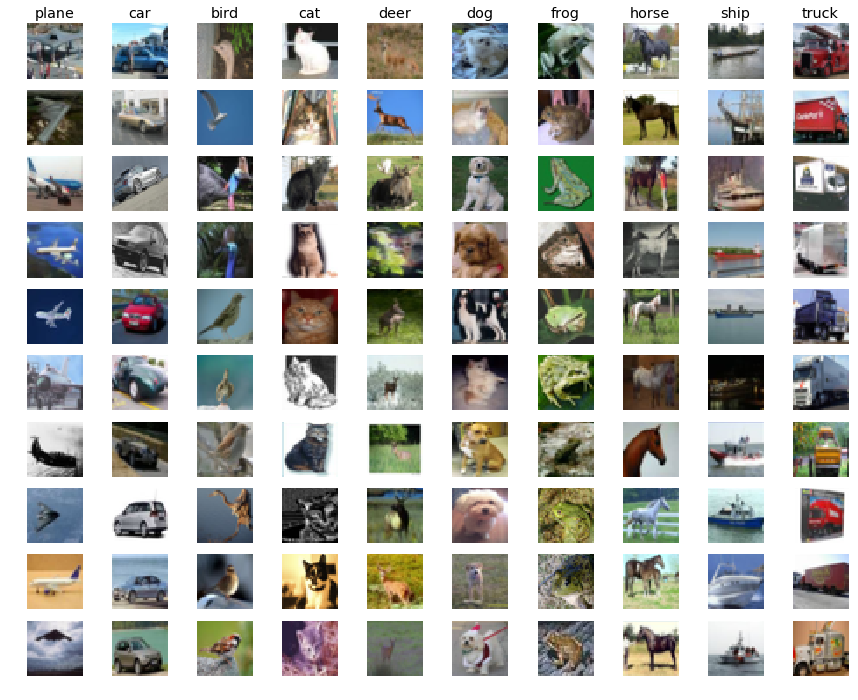

In [27]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

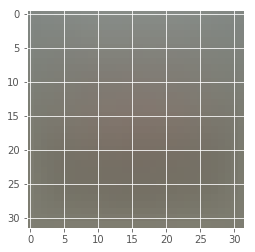

In [28]:
# Preprocessing: вычитаем среднее
# 1: Находим среднее изображение
mean_image = np.mean(x_train, axis=0)
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # визуализируем полученное среднее
plt.show()

In [29]:
# 2: вычитаем среднее из изображений обучающей и тестовых выборок
x_train = x_train - mean_image
x_test = x_test - mean_image

In [30]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1000)

Попробуем решить задачу при помощи простой нейронной сети. Сначала объявим функцию, описывающую граф модели.

In [31]:
def build_simple_model():
    # placeholder'ы это точкb входа, можно восприпимать их, как аргументы функции, описываемой графом
    x = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.int64, [None])
    
    #variable scope задаёт префикс для всех элементов внутри него
    #Это позволяет огранизовавывать структуру графа и вашего кода
    with tf.variable_scope("convolution_layer_1"):
        #создаём веса (W -- ядра свёрток, b -- сдвиг)
        Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
        bconv1 = tf.get_variable("bconv1", shape=[32])
        
        a1 = tf.nn.conv2d(x, Wconv1, strides=[1,2,2,1], padding='VALID') + bconv1
        h1 = tf.nn.relu(a1)
    
    #добавляем полносвязный слой
    with tf.variable_scope("dense_layer_1"):
        W1 = tf.get_variable("W1", shape=[5408, 10])
        b1 = tf.get_variable("b1", shape=[10])
        
        h1_flat = tf.reshape(h1,[-1,5408])
        y_out = tf.matmul(h1_flat,W1) + b1

        
    # y_out -- это вектор оценок, которые генерирует модель. Теперь определим функцию потерь
    total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
    mean_loss = tf.reduce_mean(total_loss)
    
    correct_prediction = tf.equal(tf.argmax(y_out,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    #Возвращаем те узлы графа, которые нам понадобятся в дальнейшем.
    #(x,y) это входы графа, а (y_out, mean_loss) выходы, которые представляют для нас интерес
    return (x,y), (y_out, mean_loss, accuracy)

Написанная выше функция не осуществляет никаких вычислений, единственное её предназначение -- описание графа.

In [32]:
#Перед вызовом функции очистим память от графов других моделей (актуально если вы вызываете эту ячейку повторно)
tf.reset_default_graph()
(x,y), (y_out, mean_loss, accuracy) = build_simple_model()

#Теперь зададим алгоритм оптимизации
optimizer = tf.train.AdamOptimizer(5e-5) 
#train_step -- специальный служебный узел в графе, отвечающий за обратный проход
train_step = optimizer.minimize(mean_loss) 

Пожалуйста, ознакомьтесь с другими возможностями, которые предоставляет tf для описания модели. 

* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers
* BatchNorm: https://www.tensorflow.org/api_docs/python/tf/contrib/layers/batch_norm

Теперь мы можем двигаться дальше и протестировать получившуюся модель. Для этого реализуем тренировочный цикл


In [42]:
def training_loop(session, model_inputs, model_outputs, train_step, epochs=10, batch_size=64):
    #создаём индекс по всем объектам
    index = np.arange(len(x_train))
    
    #перемешиваем его
    np.random.shuffle(index)
    
    #разбиваем на батчи
    num_batches = int(len(index) / batch_size)
    batch_indexes = np.array_split(index, num_batches)
    
    #аналогично для теста
    index_test = np.arange(len(x_test))
    np.random.shuffle(index_test)
    num_batches_test = int(len(index_test) / batch_size)
    batch_indexes_test = np.array_split(index_test, num_batches_test)
    
    #аналогично для validation
    index_val = np.arange(len(x_val))
    np.random.shuffle(index_val)
    num_batches_val = int(len(index_val) / batch_size)
    batch_indexes_val = np.array_split(index_val, num_batches_val)
    
    
    x,y = model_inputs
    y_out, mean_loss, accuracy = model_outputs
    
    def train(x_values, y_values, batch_indexes):
        train_loses = []
        for i, batch_index in enumerate(batch_indexes):

            #Создаём словарь, осуществляющий сопоставление входов графа (plaseholders) и значений
            feed_dict = {x: x_values[batch_index],
                         y: y_values[batch_index]}

            #Здесь происходит непоследственный вызов модели
            #Обратите внимание, что мы передаём train_step
            scores, loss, acc, _ = session.run([y_out, mean_loss, accuracy, train_step],feed_dict=feed_dict)

            train_loses.append(loss)
            print(f'iteration {i}, train loss: {loss:.3}, accuracy: {acc:.3}', end='\r')
        return train_loses
        
    def evaluate(x_values, y_values, batch_indexes):
        test_loses = []
        test_accuracy = []

        for batch_index in batch_indexes:

            #Создаём словарь, осуществляющий сопоставление входов графа (plaseholders) и значений
            feed_dict = {x: x_values[batch_index],
                         y: y_values[batch_index]}

            #Здесь происходит непоследственный вызов модели
            loss, acc = session.run([mean_loss, accuracy],feed_dict=feed_dict)

            test_loses.append(loss)
            test_accuracy.append(acc)

        return test_loses, test_accuracy
    
    # цикл по эпохам
    for e in range(epochs):
        print(f'Epoch {e}:')
        train_loses = train(x_train, y_train, batch_indexes)
        val_loses, val_accuracy = evaluate(x_val, y_val, batch_indexes_val)
        print(f'train loss: {np.mean(train_loses):.3}, val loss: {np.mean(val_loses):.3}, accuracy: {np.mean(val_accuracy):.3}')
      
    print('================================================')
    print('Test set results:')
    test_loses, test_accuracy = evaluate(x_test, y_test, batch_indexes_test)
    print(f'test loss: {np.mean(test_loses):.3}, accuracy: {np.mean(test_accuracy):.3}')

In [40]:
# создаём сессию. Сессия -- это среда, в которой выполняются вычисления
with tf.Session() as sess:
    #мы можем явно указать устройство
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        #инициализируем веса, в этот момент происходит выделение памяти
        sess.run(tf.global_variables_initializer())
        
        #запускаем тренировку
        training_loop(sess, model_inputs=(x,y), 
                      model_outputs=(y_out, mean_loss, accuracy), 
                      train_step=train_step, epochs=20)

Epoch 0:
train loss: 1.48, val loss: 0.948, accuracy: 0.271
Epoch 1:
train loss: 0.767, val loss: 0.693, accuracy: 0.307
Epoch 2:
train loss: 0.585, val loss: 0.565, accuracy: 0.33
Epoch 3:
train loss: 0.483, val loss: 0.496, accuracy: 0.357
Epoch 4:
train loss: 0.416, val loss: 0.447, accuracy: 0.376
Epoch 5:
train loss: 0.369, val loss: 0.407, accuracy: 0.389
Epoch 6:
train loss: 0.333, val loss: 0.377, accuracy: 0.401
Epoch 7:
train loss: 0.305, val loss: 0.355, accuracy: 0.419
Epoch 8:
train loss: 0.283, val loss: 0.333, accuracy: 0.448
Epoch 9:
train loss: 0.266, val loss: 0.32, accuracy: 0.445
Epoch 10:
train loss: 0.251, val loss: 0.308, accuracy: 0.462
Epoch 11:
train loss: 0.238, val loss: 0.296, accuracy: 0.477
Epoch 12:
train loss: 0.227, val loss: 0.288, accuracy: 0.485
Epoch 13:
train loss: 0.218, val loss: 0.283, accuracy: 0.49
Epoch 14:
train loss: 0.211, val loss: 0.277, accuracy: 0.491
Epoch 15:
train loss: 0.204, val loss: 0.273, accuracy: 0.497
Epoch 16:
train loss: 

Как видим, даже самая простая модель показывает очень неплохие результаты

**Задача 1:** Модифицируйте предыдущий код так, чтобы данные о тренировке (train\val loss) выводились в tensorboard. Изучите визуализацию графа модели.

**Задача 2 (основная)** Реализуйте сеть, подобную [VGG-16](https://arxiv.org/pdf/1409.1556.pdf), для решения задачи. При реализации вам не разрешается пользоваться модулем **tf.layers** за исключением **tf.layers.batch_normalization** и **tf.layers.dropout**. Обратите внимание, что VGG-16 заточена под изображения большего разрешения.

![image.png](http://book.paddlepaddle.org/03.image_classification/image/vgg16.png)

Затем, после того, как сеть будет реализована постарайтесь получить масимально возможную точность, используя методы, описанные в лекциях (batch normalization, расписание learning rate, поменяйте функции активации, аугментация данных и т.д.). Результаты каждого слушателя затем будут занесены в таблицу и вывешены в репозитории курса.

Принимаются работы с точностью **не менее 73%**. 

Важно отметить, что с для улучшения результата, вы можете пойти дальше и изменить топологию сети. Например, использовать одну из представленных ниже 
  - [ResNets](https://arxiv.org/abs/1512.03385).
  - [DenseNets](https://arxiv.org/abs/1608.06993).
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

Напишите ваш код под текстом задания